In [5]:
# Daniel Bandala @ may 2022
import numpy as np
import matplotlib.pyplot as plt

# Training Algorithm for Self-Organizing Maps

The basic algorithm for training an SOM is given below:

* Initialize all grid weights of the SOM
* Repeat until convergence or maximum epochs are reached
* Shuffle the training examples
* For each training instance $x$
    * Find the best matching unit BMU
    * Update the weight vector of BMU and its neighboring cells
    
The three steps for initialization, finding the BMU, and updating the weights are explained in the following sections

# Learning Rate

The learning rate $\eta$ is a constant in the range $[0,1]$ and determines the step size of the weight vector towards the input training example. For $\eta =
0 $, there is no change in the weight, and when $\eta = 1$ the weight vector $w_{ij}$ take the value of $x$. Therefore, $\eta$ is kept high at the start and decayed as the epochs proceed. One strategy for reducing the learning rate during the training phase is to use exponential decay:
$$ \eta^{(t)} = \eta^{0} e^{-t\lambda}$$

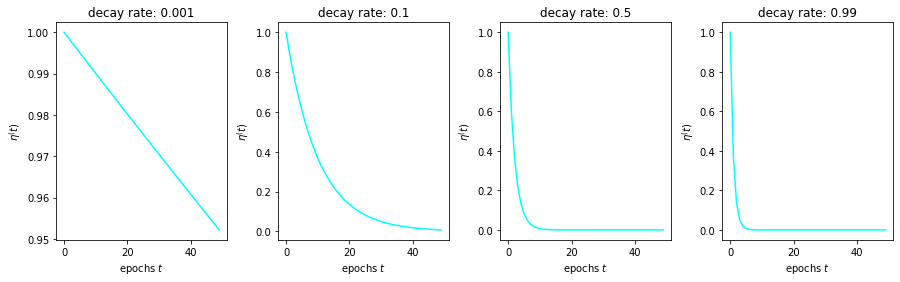

In [6]:
epochs = np.arange(0, 50)
lr_decay = [0.001, 0.1, 0.5, 0.99]
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
plt_ind = np.arange(4) + 141
for decay, ind in zip(lr_decay, plt_ind):
    plt.subplot(ind)
    learn_rate = np.exp(-epochs * decay)
    plt.plot(epochs, learn_rate, c='cyan')
    plt.title('decay rate: ' + str(decay))
    plt.xlabel('epochs $t$')
    plt.ylabel('$\eta^(t)$')
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Neighborhood Distance Function

The neighborhood distance function is given by:

$$ f_{ij}(g,h,\sigma_t) = e^{-\frac{d((i,j),(g,h))}{2\sigma^2_t}} $$


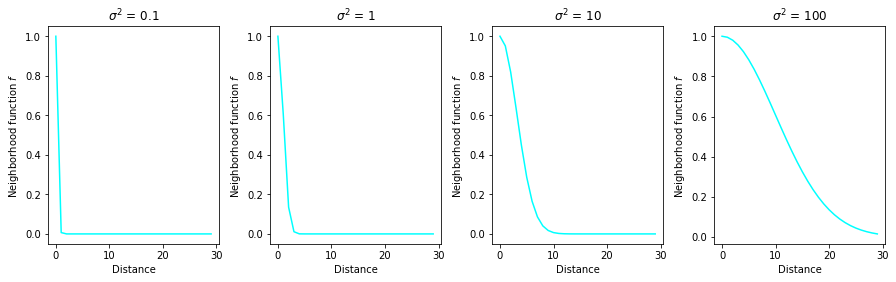

In [7]:
distance = np.arange(0, 30)
sigma_sq = [0.1, 1, 10, 100]
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
plt_ind = np.arange(4) + 141
for s, ind in zip(sigma_sq, plt_ind):
    plt.subplot(ind)
    f = np.exp(-distance ** 2 / 2 / s)
    plt.plot(distance, f, c='cyan')
    plt.title('$\sigma^2$ = ' + str(s))
    plt.xlabel('Distance')
    plt.ylabel('Neighborhood function $f$')
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Implementing a Self-Organizing Map

In [8]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

In [9]:
# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM

In [10]:
# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

# SOM on practical example

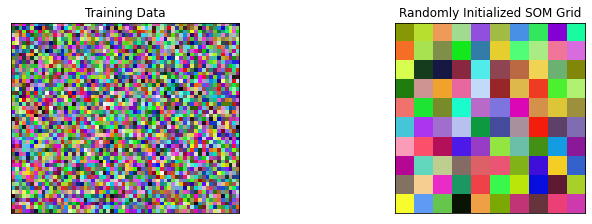

In [11]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 3000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = rand.randint(0, 255, (n_x, 3))
# Initialize the SOM randomly
SOM = rand.randint(0, 255, (m, n, 3)).astype(float)
# Display both the training matrix and the SOM grid
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(train_data.reshape(50, 60, 3))
ax[0].title.set_text('Training Data')
ax[1].imshow(SOM.astype(int))
ax[1].title.set_text('Randomly Initialized SOM Grid')

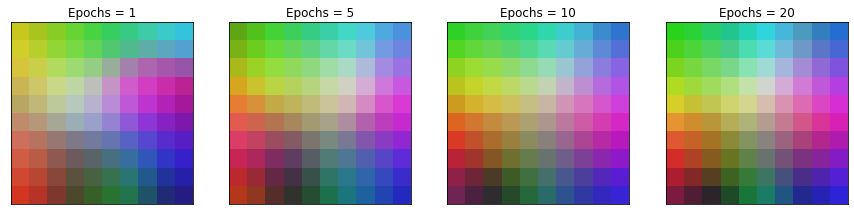

In [12]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
for epochs, i in zip([1, 4, 5, 10], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, train_data, epochs=epochs)
    ax[i].imshow(SOM.astype(int))
    ax[i].title.set_text('Epochs = ' + str(total_epochs))

# Effect of Learning Rate and Radius
To see how the learning rate varies for different learning rates and radii, we can run the SOM for 10 epochs when starting from the same initial grid. The code below trains the SOM for three different values of the learning rate and three different radii.

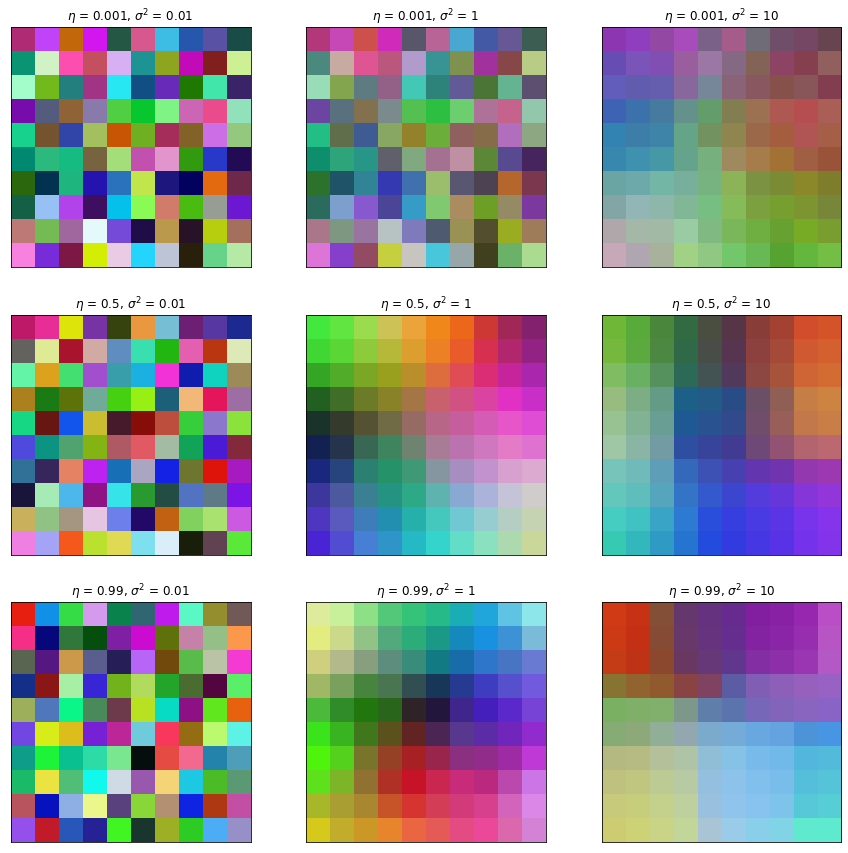

In [13]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, figsize=(15, 15), 
    subplot_kw=dict(xticks=[], yticks=[]))

# Initialize the SOM randomly to the same state

for learn_rate, i in zip([0.001, 0.5, 0.99], [0, 1, 2]):
    for radius_sq, j in zip([0.01, 1, 10], [0, 1, 2]):
        rand = np.random.RandomState(0)
        SOM = rand.randint(0, 255, (m, n, 3)).astype(float)        
        SOM = train_SOM(SOM, train_data, epochs = 5,
                        learn_rate = learn_rate, 
                        radius_sq = radius_sq)
        ax[i][j].imshow(SOM.astype(int))
        ax[i][j].title.set_text('$\eta$ = ' + str(learn_rate) + 
                                ', $\sigma^2$ = ' + str(radius_sq))

# Using Sklearn library

In [19]:
from sklearn_som.som import SOM
from sklearn import datasets
from matplotlib.colors import ListedColormap

In [15]:
iris = datasets.load_iris()
iris_data = iris.data[:, :2]
iris_label = iris.target

In [16]:
iris_som = SOM(m=3, n=1, dim=2)
iris_som.fit(iris_data)

In [17]:
predictions = iris_som.predict(iris_data)

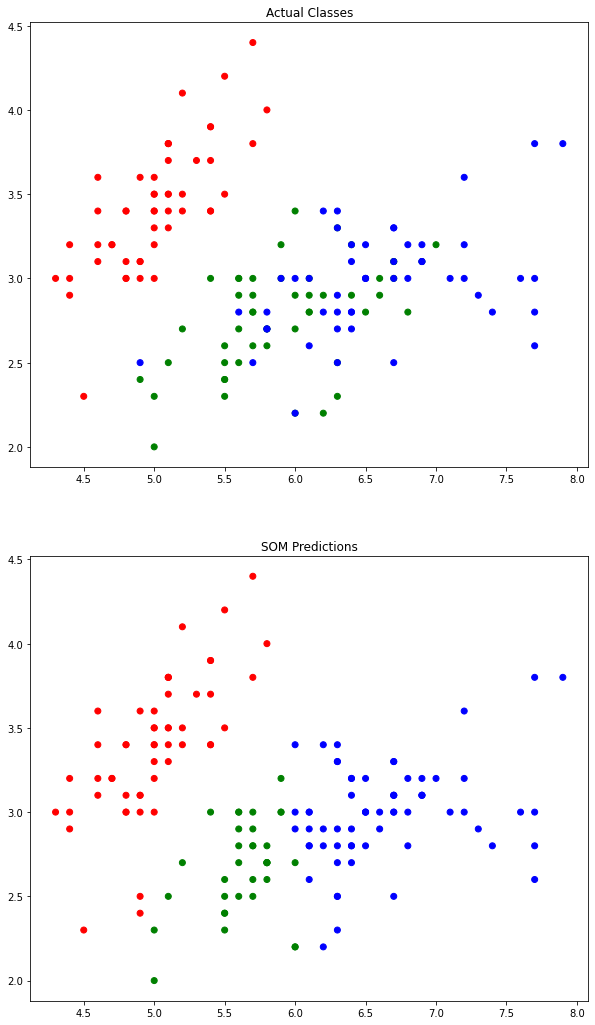

In [25]:
# Plot the results
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,18))
x = iris_data[:,0]
y = iris_data[:,1]
colors = ['red', 'green', 'blue']
ax[0].scatter(x, y, c=iris_label, cmap=ListedColormap(colors))
ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, c=predictions, cmap=ListedColormap(colors))
ax[1].title.set_text('SOM Predictions')
plt.savefig('iris_example.png')